In [46]:

import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.models as models
import torch.optim as optim
import os
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
import torchattacks
import matplotlib.pyplot as plt

### Hyperparameters

In [47]:
model_name = "VGG"
version = "v7"
training_name = "AT"
num_classes = 7
batch_size = 32
learning_rate = 0.0001
lr_factor = 0.1
lr_threshold = 5
epochs = 100
height = 224

epsilon = 8.0/255
alpha = 2.0/255
steps = 10

In [48]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.cuda.empty_cache()
# Graph writer initialize
writer = SummaryWriter("runs/trashbox/" + f'{training_name}--{model_name}.{version}')

In [49]:
# class MinMaxNormalization(object):
#     def __init__(self, min_val=0, max_val=1):
#         self.min_val = min_val
#         self.max_val = max_val

#     def __call__(self, tensor):
#         # Calculate the minimum and maximum values of the tensor
#         min_tensor = tensor.min()
#         max_tensor = tensor.max()

#         # Perform min-max normalization
#         normalized_tensor = (tensor - min_tensor) / (max_tensor - min_tensor) * (self.max_val - self.min_val) + self.min_val

#         return normalized_tensor
    
# min_max_normalizer = MinMaxNormalization(min_val=0, max_val=1)

In [50]:
# mean = torch.tensor([0.485, 0.456, 0.406])
# std = torch.tensor([0.229, 0.224, 0.225])

### Preprocessing

In [51]:
preprocessing = transforms.Compose([
    transforms.RandomResizedCrop((height, height)),
    transforms.ToTensor(),
    # transforms.Normalize(mean=mean, std=std)
])

### Dataset

In [52]:
trash_train_dataset = torchvision.datasets.ImageFolder('dataset/trashbox/train', transform=preprocessing)
trash_train_loader = torch.utils.data.DataLoader(dataset=trash_train_dataset, shuffle=True, batch_size=batch_size)
trash_val_dataset = torchvision.datasets.ImageFolder('dataset/trashbox/val', transform=preprocessing)
trash_val_loader = torch.utils.data.DataLoader(dataset=trash_val_dataset, shuffle=True, batch_size=batch_size)

### Model

In [53]:
weights = models.GoogLeNet_Weights.DEFAULT
model = models.googlenet(weights=weights)
infeatures = model.fc.in_features
model.fc = nn.Linear(infeatures, num_classes, True)
model = model.to(device)

# checkpoint = torch.load('./best_trained_models/best_NORMAL--VGG16.v1_epoch49.pth')

# if 'module' in list(checkpoint['net'].keys())[0]:
#     new_state_dict = {k.replace("module.", ""): v for k, v in checkpoint['net'].items()}
#     model.load_state_dict(new_state_dict)
# else:
#     model.load_state_dict(checkpoint['net'])
model = torch.nn.DataParallel(model)

### Attack; Criterion

In [54]:
atk = torchattacks.PGD(model, epsilon, alpha, steps)
criterion = nn.CrossEntropyLoss()

### Preview of image

tensor(1.)
tensor(0.)


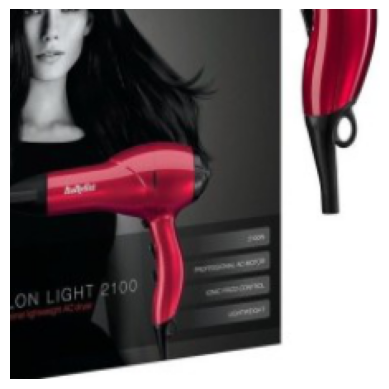

In [55]:
examples = iter(trash_val_loader)
samples, labels = next(examples)

if samples.ndim > 3:
    new_samples = samples.squeeze()

    # If the tensor has 4 dimensions (batch dimension), select the first image in the batch
if samples.ndim == 4:
    new_samples = samples[0]
image_array = new_samples.permute(1, 2, 0).numpy()

# Show min and max values for normalization
print(torch.max(samples))
print(torch.min(samples))

plt.imshow(image_array)
plt.axis('off')  # Turn off axis labels
plt.show()

### Preview of Adversarial sample

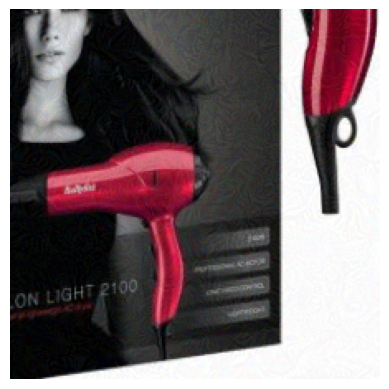

In [56]:
adv_image = atk(samples, labels)
adv_image = adv_image.cpu().detach()

if adv_image.ndim > 3:
    new_adv_samples = adv_image.squeeze()

    # If the tensor has 4 dimensions (batch dimension), select the first image in the batch
if adv_image.ndim == 4:
    new_adv_samples = adv_image[0]
image_array = new_adv_samples.permute(1, 2, 0).numpy()
plt.imshow(image_array)
plt.axis('off')  # Turn off axis labels
plt.show()

In [57]:
def train(epoch, optimizer): 
    print(f'Train epoch no. [{epoch}]')
    train_loss = 0
    correct = 0
    total = 0
    model.train()
    iterator = tqdm(trash_train_loader, ncols=0, leave=False)
    for i, (inputs, targets)in enumerate(iterator):
        inputs, targets = inputs.to(device),targets.to(device)

        optimizer.zero_grad()

        adv_sample = atk(inputs, targets)
        adv_output = model(adv_sample)
        loss = criterion(adv_output, targets)
        loss.backward()

        optimizer.step()
        train_loss += loss.item()
        _, predicted = adv_output.max(1)

        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
    validation_loss = train_loss / len(trash_train_loader)
    print('\nTotal train accuarcy:', 100. * correct / total)
    print('Validation loss:', validation_loss)
    print('Total train loss:', train_loss)
    
    writer.add_scalar('Adversarial Train loss: ' + model_name, validation_loss, epoch)
    writer.add_scalar('Adversarial Train accuracy: ' + model_name, 100. * correct / total, epoch)
    return train_loss

In [58]:
import torch.utils


best_loss = float('inf')

def test(epoch, optimizer):
    print('\n[ Test epoch: %d ]' % epoch)
    global best_loss
    model.eval()
    benigh_loss = 0
    adv_loss = 0
    adv_correct = 0
    correct = 0
    total = 0
    with torch.no_grad():
        iterator = tqdm(trash_val_loader, ncols=0, leave=False)
        for i, (inputs, targets) in enumerate(iterator):
            inputs, targets = inputs.to(device), targets.to(device)
            total += targets.size(0)
            # For clean images
            output = model(inputs)
            clean_loss = criterion(output, targets)
            benigh_loss += clean_loss.item()

            _, predicted = output.max(1)
            correct += predicted.eq(targets).sum().item()
            ## For adversarial 
            with torch.enable_grad(): 
                adv_image = atk(inputs, targets)
            adv_image = adv_image.to(device)
            adv_outputs = model(adv_image)
            adv_loss = criterion(adv_outputs, targets)
            adv_loss += adv_loss.item()

            _, adv_predicted = adv_outputs.max(1)
            adv_correct += adv_predicted.eq(targets).sum().item()

    benign_validation_loss = benigh_loss / len(trash_val_loader)
    adv_validation_loss = benigh_loss / len(trash_val_loader)
    benign_accuracy = correct / total
    adv_accuracy = adv_correct / total

    print('\nTest accuarcy:', 100. * correct / total)
    print('Test loss:', benign_validation_loss)
    print('\nTest accuarcy:', 100. * adv_correct / total)
    print('Test loss:', adv_validation_loss)

    # Graph
    writer.add_scalar("Test accuracy: " + model_name, 100. * benign_accuracy, epoch)
    writer.add_scalar("Test loss: " + model_name, benign_validation_loss, epoch)
    writer.add_scalar("Adversarial Test accuracy: " + model_name, 100. * adv_accuracy, epoch)
    writer.add_scalar("Adversarial Test loss: " + model_name, adv_validation_loss, epoch)

    # Save checkpoint
    state = {
        'epoch' : epoch,
        'net': model.state_dict(),
        'optim' : optimizer.state_dict(),
        'loss' : adv_loss
    }

    if not os.path.isdir('checkpoint'):
        os.mkdir('checkpoint')
    torch.save(state, './checkpoint/' + f'{training_name}--{model_name}.{version}.pth')
    print('Model Saved!')

    if benign_validation_loss < best_loss:
        print(f'New best loss saved: {benign_validation_loss}')
        best_loss = benign_validation_loss
        torch.save(state, './trained_model/' + f'best_{training_name}--{model_name}.{version}_epoch{epoch}.pth')
    return benign_accuracy, adv_accuracy, benign_validation_loss, adv_validation_loss

In [59]:
def main():
    global learning_rate
    learning_rate = learning_rate
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.0002)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=lr_threshold, factor=0.1)

    model_path = f'./checkpoint/{training_name}--{model_name}.{version}.pth'
    if os.path.exists(model_path):
        # Load the saved model and optimizer state
        checkpoint = torch.load(model_path)
        model.load_state_dict(checkpoint['net'])
        optimizer.load_state_dict(checkpoint['optim'])
        start_epoch = checkpoint['epoch']
        print(f"=> Loaded checkpoint '{model_path}' (epoch {start_epoch})")
    else:
        start_epoch = 0
        print(f"=> No checkpoint found at '{model_path}'. Starting training from scratch.")

    for epoch in range(start_epoch, epochs):
        train_loss = train(epoch, optimizer)
        _, _, benign_validation_loss, _ = test(epoch, optimizer)
        scheduler.step(metrics=benign_validation_loss, epoch=epoch)
        scheduler.print_lr(True, model.parameters(), learning_rate, epoch)


In [60]:
if __name__ == '__main__':
    main()

=> Loaded checkpoint './checkpoint/AT--Googlenet.v1.pth' (epoch 49)
Train epoch no. [49]


  1% 5/447 [00:06<08:44,  1.19s/it]c:\Users\MY PC\anaconda3\envs\thesisaimodel\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



Total train accuarcy: 44.2117795363821
Validation loss: 1.473043085744717
Total train loss: 658.4502593278885

[ Test epoch: 49 ]



Test accuarcy: 62.886019090398655
Test loss: 1.1088306701609068

Test accuarcy: 40.81976417742841
Test loss: 1.1088306701609068
Model Saved!
New best loss saved: 1.1088306701609068


c:\Users\MY PC\anaconda3\envs\thesisaimodel\Lib\site-packages\torch\optim\lr_scheduler.py:1056: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 00049: adjusting learning rate of group <generator object Module.parameters at 0x0000027215D52260> to 1.0000e-04.
Train epoch no. [50]



Total train accuarcy: 44.33783878422859
Validation loss: 1.4698934451045607
Total train loss: 657.0423699617386

[ Test epoch: 50 ]



Test accuarcy: 60.92083099382369
Test loss: 1.1576188781431742

Test accuarcy: 39.69679955081415
Test loss: 1.1576188781431742
Model Saved!
Epoch 00050: adjusting learning rate of group <generator object Module.parameters at 0x0000027215D511C0> to 1.0000e-04.
Train epoch no. [51]



Total train accuarcy: 44.80005602633238
Validation loss: 1.4577303847477208
Total train loss: 651.6054819822311

[ Test epoch: 51 ]



Test accuarcy: 61.426165075800114
Test loss: 1.1165452684674944

Test accuarcy: 40.707467714766985
Test loss: 1.1165452684674944
Model Saved!
Epoch 00051: adjusting learning rate of group <generator object Module.parameters at 0x0000027215D50120> to 1.0000e-04.
Train epoch no. [52]



Total train accuarcy: 45.115204145948596
Validation loss: 1.4550148262006857
Total train loss: 650.3916273117065

[ Test epoch: 52 ]



Test accuarcy: 64.00898371701291
Test loss: 1.0929432649697577

Test accuarcy: 40.81976417742841
Test loss: 1.0929432649697577
Model Saved!
New best loss saved: 1.0929432649697577
Epoch 00052: adjusting learning rate of group <generator object Module.parameters at 0x0000027215D511C0> to 1.0000e-04.
Train epoch no. [53]



Total train accuarcy: 45.35331605854752
Validation loss: 1.4504579497663768
Total train loss: 648.3547035455704

[ Test epoch: 53 ]



Test accuarcy: 62.886019090398655
Test loss: 1.0997716678040368

Test accuarcy: 39.58450308815272
Test loss: 1.0997716678040368
Model Saved!
Epoch 00053: adjusting learning rate of group <generator object Module.parameters at 0x0000027215D511C0> to 1.0000e-04.
Train epoch no. [54]



Total train accuarcy: 45.29028643462427
Validation loss: 1.4466418934615133
Total train loss: 646.6489263772964

[ Test epoch: 54 ]



Test accuarcy: 64.51431779898934
Test loss: 1.0765981642263276

Test accuarcy: 41.83043234138125
Test loss: 1.0765981642263276
Model Saved!
New best loss saved: 1.0765981642263276
Epoch 00054: adjusting learning rate of group <generator object Module.parameters at 0x0000026FEE592260> to 1.0000e-04.
Train epoch no. [55]



Total train accuarcy: 45.500385181035085
Validation loss: 1.440587284580973
Total train loss: 643.942516207695

[ Test epoch: 55 ]



Test accuarcy: 60.92083099382369
Test loss: 1.1068770970617021

Test accuarcy: 39.35991016282987
Test loss: 1.1068770970617021
Model Saved!
Epoch 00055: adjusting learning rate of group <generator object Module.parameters at 0x0000027215D511C0> to 1.0000e-04.
Train epoch no. [56]



Total train accuarcy: 45.584424679599415
Validation loss: 1.4326732246667746
Total train loss: 640.4049314260483

[ Test epoch: 56 ]



Test accuarcy: 63.55979786636721
Test loss: 1.0780869126319885

Test accuarcy: 41.10050533408198
Test loss: 1.0780869126319885
Model Saved!
Epoch 00056: adjusting learning rate of group <generator object Module.parameters at 0x0000027215D511C0> to 1.0000e-04.
Train epoch no. [57]



Total train accuarcy: 46.24973737656698
Validation loss: 1.424618721808363
Total train loss: 636.8045686483383

[ Test epoch: 57 ]



Test accuarcy: 63.89668725435149
Test loss: 1.0836042282836778

Test accuarcy: 40.988208871420554
Test loss: 1.0836042282836778
Model Saved!
Epoch 00057: adjusting learning rate of group <generator object Module.parameters at 0x0000027215D52260> to 1.0000e-04.
Train epoch no. [58]



Total train accuarcy: 46.4598361229778
Validation loss: 1.4236768710799932
Total train loss: 636.383561372757

[ Test epoch: 58 ]



Test accuarcy: 64.7950589556429
Test loss: 1.078973108104297

Test accuarcy: 40.370578326782706
Test loss: 1.078973108104297
Model Saved!
Epoch 00058: adjusting learning rate of group <generator object Module.parameters at 0x0000027215D50C80> to 1.0000e-04.
Train epoch no. [59]



Total train accuarcy: 46.31276700049023
Validation loss: 1.4208752468928394
Total train loss: 635.1312353610992

[ Test epoch: 59 ]



Test accuarcy: 63.840539023020774
Test loss: 1.0731247748647417

Test accuarcy: 41.10050533408198
Test loss: 1.0731247748647417
Model Saved!
New best loss saved: 1.0731247748647417
Epoch 00059: adjusting learning rate of group <generator object Module.parameters at 0x0000027215D511C0> to 1.0000e-04.
Train epoch no. [60]



Total train accuarcy: 46.753974367952935
Validation loss: 1.411373197232317
Total train loss: 630.8838191628456

[ Test epoch: 60 ]



Test accuarcy: 63.784390791690065
Test loss: 1.0617095093641962

Test accuarcy: 40.14598540145985
Test loss: 1.0617095093641962
Model Saved!
New best loss saved: 1.0617095093641962
Epoch 00060: adjusting learning rate of group <generator object Module.parameters at 0x0000026FEE592260> to 1.0000e-04.
Train epoch no. [61]



Total train accuarcy: 46.60690524546537
Validation loss: 1.4108333208950308
Total train loss: 630.6424944400787

[ Test epoch: 61 ]



Test accuarcy: 63.840539023020774
Test loss: 1.0553949773311615

Test accuarcy: 40.7636159460977
Test loss: 1.0553949773311615
Model Saved!
New best loss saved: 1.0553949773311615
Epoch 00061: adjusting learning rate of group <generator object Module.parameters at 0x0000026FEE592260> to 1.0000e-04.
Train epoch no. [62]



Total train accuarcy: 47.55935289586105
Validation loss: 1.3986559188872643
Total train loss: 625.1991957426071

[ Test epoch: 62 ]



Test accuarcy: 64.90735541830432
Test loss: 1.0455903421555246

Test accuarcy: 42.784952274003366
Test loss: 1.0455903421555246
Model Saved!
New best loss saved: 1.0455903421555246
Epoch 00062: adjusting learning rate of group <generator object Module.parameters at 0x0000027215D52260> to 1.0000e-04.
Train epoch no. [63]



Total train accuarcy: 47.09013236221024
Validation loss: 1.3998123852731932
Total train loss: 625.7161362171173

[ Test epoch: 63 ]



Test accuarcy: 65.2442448062886
Test loss: 1.0544798150658607

Test accuarcy: 42.39191465468838
Test loss: 1.0544798150658607
Model Saved!
Epoch 00063: adjusting learning rate of group <generator object Module.parameters at 0x0000027215D52260> to 1.0000e-04.
Train epoch no. [64]



Total train accuarcy: 47.8815043070243
Validation loss: 1.3851914576502722
Total train loss: 619.1805815696716

[ Test epoch: 64 ]



Test accuarcy: 64.17742841100505
Test loss: 1.0705223722117287

Test accuarcy: 41.04435710275126
Test loss: 1.0705223722117287
Model Saved!
Epoch 00064: adjusting learning rate of group <generator object Module.parameters at 0x0000027215D50C80> to 1.0000e-04.
Train epoch no. [65]



Total train accuarcy: 47.48231668884376
Validation loss: 1.391108662890108
Total train loss: 621.8255723118782

[ Test epoch: 65 ]



Test accuarcy: 64.12128017967434
Test loss: 1.0407416767307691

Test accuarcy: 41.661987647389104
Test loss: 1.0407416767307691
Model Saved!
New best loss saved: 1.0407416767307691
Epoch 00065: adjusting learning rate of group <generator object Module.parameters at 0x0000027215D511C0> to 1.0000e-04.
Train epoch no. [66]



Total train accuarcy: 47.85349114083619
Validation loss: 1.381046903480086
Total train loss: 617.3279658555984

[ Test epoch: 66 ]



Test accuarcy: 65.07580011229646
Test loss: 1.0220107734203339

Test accuarcy: 42.67265581134194
Test loss: 1.0220107734203339
Model Saved!
New best loss saved: 1.0220107734203339
Epoch 00066: adjusting learning rate of group <generator object Module.parameters at 0x0000027215D511C0> to 1.0000e-04.
Train epoch no. [67]



Total train accuarcy: 47.85349114083619
Validation loss: 1.3778642062639497
Total train loss: 615.9053001999855

[ Test epoch: 67 ]



Test accuarcy: 61.93149915777653
Test loss: 1.0953346874032701

Test accuarcy: 40.707467714766985
Test loss: 1.0953346874032701
Model Saved!
Epoch 00067: adjusting learning rate of group <generator object Module.parameters at 0x0000027215D511C0> to 1.0000e-04.
Train epoch no. [68]



Total train accuarcy: 48.53981371244485
Validation loss: 1.3714650840033888
Total train loss: 613.0448925495148

[ Test epoch: 68 ]



Test accuarcy: 64.00898371701291
Test loss: 1.0430030418293816

Test accuarcy: 42.27961819202695
Test loss: 1.0430030418293816
Model Saved!
Epoch 00068: adjusting learning rate of group <generator object Module.parameters at 0x0000027215D50C80> to 1.0000e-04.
Train epoch no. [69]



Total train accuarcy: 49.10708032775405
Validation loss: 1.359032368366617
Total train loss: 607.4874686598778

[ Test epoch: 69 ]



Test accuarcy: 65.07580011229646
Test loss: 1.0452512534601348

Test accuarcy: 41.49354295339697
Test loss: 1.0452512534601348
Model Saved!
Epoch 00069: adjusting learning rate of group <generator object Module.parameters at 0x0000027215D50120> to 1.0000e-04.
Train epoch no. [70]



Total train accuarcy: 48.17564255199944
Validation loss: 1.3645469696996462
Total train loss: 609.9524954557419

[ Test epoch: 70 ]



Test accuarcy: 65.35654126895002
Test loss: 1.022703698703221

Test accuarcy: 41.661987647389104
Test loss: 1.022703698703221
Model Saved!
Epoch 00070: adjusting learning rate of group <generator object Module.parameters at 0x0000027215D50120> to 1.0000e-04.
Train epoch no. [71]



Total train accuarcy: 49.21913299250648
Validation loss: 1.3552463039989173
Total train loss: 605.795097887516

[ Test epoch: 71 ]



Test accuarcy: 65.97417181358787
Test loss: 1.0261794988598143

Test accuarcy: 43.17798989331836
Test loss: 1.0261794988598143
Model Saved!
Epoch 00071: adjusting learning rate of group <generator object Module.parameters at 0x0000027215D50C80> to 1.0000e-04.
Train epoch no. [72]



Total train accuarcy: 49.08607045311296
Validation loss: 1.3590091024202522
Total train loss: 607.4770687818527

[ Test epoch: 72 ]



Test accuarcy: 63.39135317237507
Test loss: 1.0105924318943704

Test accuarcy: 40.707467714766985
Test loss: 1.0105924318943704
Model Saved!
New best loss saved: 1.0105924318943704
Epoch 00072: adjusting learning rate of group <generator object Module.parameters at 0x0000027215D50C80> to 1.0000e-04.
Train epoch no. [73]



Total train accuarcy: 49.05105399537783
Validation loss: 1.3514935596943969
Total train loss: 604.1176211833954

[ Test epoch: 73 ]



Test accuarcy: 64.4020213363279
Test loss: 1.0457756104213851

Test accuarcy: 42.33576642335766
Test loss: 1.0457756104213851
Model Saved!
Epoch 00073: adjusting learning rate of group <generator object Module.parameters at 0x0000027215D50C80> to 1.0000e-04.
Train epoch no. [74]



Total train accuarcy: 49.324182365711884
Validation loss: 1.3414979353047056
Total train loss: 599.6495770812035

[ Test epoch: 74 ]



Test accuarcy: 65.41268950028073
Test loss: 1.0165215145264352

Test accuarcy: 41.71813587871982
Test loss: 1.0165215145264352
Model Saved!
Epoch 00074: adjusting learning rate of group <generator object Module.parameters at 0x0000027215D52260> to 1.0000e-04.
Train epoch no. [75]



Total train accuarcy: 49.31017578261783
Validation loss: 1.3462214873941152
Total train loss: 601.7610048651695

[ Test epoch: 75 ]



Test accuarcy: 65.30039303761932
Test loss: 1.0313403010368347

Test accuarcy: 41.83043234138125
Test loss: 1.0313403010368347
Model Saved!
Epoch 00075: adjusting learning rate of group <generator object Module.parameters at 0x0000027215D50C80> to 1.0000e-04.
Train epoch no. [76]



Total train accuarcy: 49.758386441627565
Validation loss: 1.3348115839947523
Total train loss: 596.6607780456543

[ Test epoch: 76 ]



Test accuarcy: 64.62661426165076
Test loss: 1.032559143645423

Test accuarcy: 42.39191465468838
Test loss: 1.032559143645423
Model Saved!
Epoch 00076: adjusting learning rate of group <generator object Module.parameters at 0x0000027215D50C80> to 1.0000e-04.
Train epoch no. [77]



Total train accuarcy: 50.82989004832271
Validation loss: 1.3230627464501383
Total train loss: 591.4090476632118

[ Test epoch: 77 ]



Test accuarcy: 65.52498596294217
Test loss: 1.0059185709272112

Test accuarcy: 42.67265581134194
Test loss: 1.0059185709272112
Model Saved!
New best loss saved: 1.0059185709272112
Epoch 00077: adjusting learning rate of group <generator object Module.parameters at 0x0000027215D50C80> to 1.0000e-04.
Train epoch no. [78]



Total train accuarcy: 50.09454443588486
Validation loss: 1.3292595501447417
Total train loss: 594.1790189146996

[ Test epoch: 78 ]



Test accuarcy: 64.62661426165076
Test loss: 1.0014094752924783

Test accuarcy: 42.84110050533408
Test loss: 1.0014094752924783
Model Saved!
New best loss saved: 1.0014094752924783
Epoch 00078: adjusting learning rate of group <generator object Module.parameters at 0x0000026FEE592260> to 1.0000e-04.
Train epoch no. [79]



Total train accuarcy: 50.89992296379298
Validation loss: 1.3197774363044124
Total train loss: 589.9405140280724

[ Test epoch: 79 ]



Test accuarcy: 66.08646827624929
Test loss: 0.9884763743196215

Test accuarcy: 42.72880404267266
Test loss: 0.9884763743196215
Model Saved!
New best loss saved: 0.9884763743196215
Epoch 00079: adjusting learning rate of group <generator object Module.parameters at 0x0000026FEE592260> to 1.0000e-04.
Train epoch no. [80]



Total train accuarcy: 50.8789130891519
Validation loss: 1.3182171015131394
Total train loss: 589.2430443763733

[ Test epoch: 80 ]



Test accuarcy: 66.19876473891073
Test loss: 1.0060240456036158

Test accuarcy: 43.065693430656935
Test loss: 1.0060240456036158
Model Saved!
Epoch 00080: adjusting learning rate of group <generator object Module.parameters at 0x0000027215D511C0> to 1.0000e-04.
Train epoch no. [81]



Total train accuarcy: 50.89992296379298
Validation loss: 1.3112689890050782
Total train loss: 586.1372380852699

[ Test epoch: 81 ]



Test accuarcy: 66.59180235822572
Test loss: 1.0044028301324164

Test accuarcy: 41.2128017967434
Test loss: 1.0044028301324164
Model Saved!
Epoch 00081: adjusting learning rate of group <generator object Module.parameters at 0x0000027215D511C0> to 1.0000e-04.
Train epoch no. [82]



Total train accuarcy: 50.78787029904055
Validation loss: 1.3167804388925266
Total train loss: 588.6008561849594

[ Test epoch: 82 ]



Test accuarcy: 67.09713644020214
Test loss: 0.9961436071566173

Test accuarcy: 42.0550252667041
Test loss: 0.9961436071566173
Model Saved!
Epoch 00082: adjusting learning rate of group <generator object Module.parameters at 0x0000027215D50C80> to 1.0000e-04.
Train epoch no. [83]



Total train accuarcy: 51.25709083269137
Validation loss: 1.3003100730162072
Total train loss: 581.2386026382446

[ Test epoch: 83 ]



Test accuarcy: 66.25491297024143
Test loss: 1.0110340916684695

Test accuarcy: 41.268950028074116
Test loss: 1.0110340916684695
Model Saved!
Epoch 00083: adjusting learning rate of group <generator object Module.parameters at 0x0000027215D50120> to 1.0000e-04.
Train epoch no. [84]



Total train accuarcy: 51.41816653827299
Validation loss: 1.2987391958034011
Total train loss: 580.5364205241203

[ Test epoch: 84 ]



Test accuarcy: 67.20943290286355
Test loss: 0.9958962021129472

Test accuarcy: 42.39191465468838
Test loss: 0.9958962021129472
Model Saved!
Epoch 00084: adjusting learning rate of group <generator object Module.parameters at 0x0000027215D50C80> to 1.0000e-04.
Train epoch no. [85]



Total train accuarcy: 51.096015127109744
Validation loss: 1.297275236922356
Total train loss: 579.8820309042931

[ Test epoch: 85 ]



Test accuarcy: 68.05165637282425
Test loss: 0.9708450841052192

Test accuarcy: 42.11117349803481
Test loss: 0.9708450841052192
Model Saved!
New best loss saved: 0.9708450841052192
Epoch 00085: adjusting learning rate of group <generator object Module.parameters at 0x0000027215D511C0> to 1.0000e-04.
Train epoch no. [86]



Total train accuarcy: 51.79634428181245
Validation loss: 1.294968026463084
Total train loss: 578.8507078289986

[ Test epoch: 86 ]



Test accuarcy: 67.09713644020214
Test loss: 0.9863943191511291

Test accuarcy: 42.27961819202695
Test loss: 0.9863943191511291
Model Saved!
Epoch 00086: adjusting learning rate of group <generator object Module.parameters at 0x0000027215D511C0> to 1.0000e-04.
Train epoch no. [87]



Total train accuarcy: 51.887387071923804
Validation loss: 1.2809105224790722
Total train loss: 572.5670035481453

[ Test epoch: 87 ]



Test accuarcy: 68.83773161145425
Test loss: 0.9771990903786251

Test accuarcy: 42.27961819202695
Test loss: 0.9771990903786251
Model Saved!
Epoch 00087: adjusting learning rate of group <generator object Module.parameters at 0x0000027215D511C0> to 1.0000e-04.
Train epoch no. [88]



Total train accuarcy: 51.68429161706002
Validation loss: 1.2791637474258475
Total train loss: 571.7861950993538

[ Test epoch: 88 ]



Test accuarcy: 67.04098820887143
Test loss: 0.9827692317111152

Test accuarcy: 41.605839416058394
Test loss: 0.9827692317111152
Model Saved!
Epoch 00088: adjusting learning rate of group <generator object Module.parameters at 0x0000027215D511C0> to 1.0000e-04.
Train epoch no. [89]



Total train accuarcy: 52.08347923524056
Validation loss: 1.2763924848046613
Total train loss: 570.5474407076836

[ Test epoch: 89 ]



Test accuarcy: 65.74957888826502
Test loss: 0.9864547071712357

Test accuarcy: 43.17798989331836
Test loss: 0.9864547071712357
Model Saved!
Epoch 00089: adjusting learning rate of group <generator object Module.parameters at 0x0000027215D50120> to 1.0000e-04.
Train epoch no. [90]



Total train accuarcy: 52.90986763778976
Validation loss: 1.2746099803005022
Total train loss: 569.7506611943245

[ Test epoch: 90 ]



Test accuarcy: 66.08646827624929
Test loss: 1.0096883199044637

Test accuarcy: 41.10050533408198
Test loss: 1.0096883199044637
Model Saved!
Epoch 00090: adjusting learning rate of group <generator object Module.parameters at 0x0000027215D50120> to 1.0000e-04.
Train epoch no. [91]



Total train accuarcy: 52.797814973037326
Validation loss: 1.2575154725870563
Total train loss: 562.1094162464142

[ Test epoch: 91 ]



Test accuarcy: 67.3778775968557
Test loss: 0.9611159573708262

Test accuarcy: 43.00954519932622
Test loss: 0.9611159573708262
Model Saved!
New best loss saved: 0.9611159573708262
Epoch 00091: adjusting learning rate of group <generator object Module.parameters at 0x0000027215D50C80> to 1.0000e-04.
Train epoch no. [92]



Total train accuarcy: 52.67175572519084
Validation loss: 1.2632475252652862
Total train loss: 564.6716437935829

[ Test epoch: 92 ]



Test accuarcy: 66.64795058955643
Test loss: 1.0117560454777308

Test accuarcy: 42.27961819202695
Test loss: 1.0117560454777308
Model Saved!
Epoch 00092: adjusting learning rate of group <generator object Module.parameters at 0x0000027215D511C0> to 1.0000e-04.
Train epoch no. [93]



Total train accuarcy: 52.762798515302194
Validation loss: 1.2730872041693737
Total train loss: 569.06998026371

[ Test epoch: 93 ]



Test accuarcy: 68.33239752947782
Test loss: 0.9579473340085575

Test accuarcy: 43.29028635597979
Test loss: 0.9579473340085575
Model Saved!
New best loss saved: 0.9579473340085575
Epoch 00093: adjusting learning rate of group <generator object Module.parameters at 0x0000027215D52260> to 1.0000e-04.
Train epoch no. [94]



Total train accuarcy: 52.699768891378945
Validation loss: 1.2661012521792845
Total train loss: 565.9472597241402

[ Test epoch: 94 ]



Test accuarcy: 67.65861875350926
Test loss: 0.9756734211530004

Test accuarcy: 42.11117349803481
Test loss: 0.9756734211530004
Model Saved!
Epoch 00094: adjusting learning rate of group <generator object Module.parameters at 0x0000027215D50C80> to 1.0000e-04.
Train epoch no. [95]



Total train accuarcy: 52.95889067861895
Validation loss: 1.2586209320648671
Total train loss: 562.6035566329956

[ Test epoch: 95 ]



Test accuarcy: 65.74957888826502
Test loss: 1.0068159763302122

Test accuarcy: 39.86524424480629
Test loss: 1.0068159763302122
Model Saved!
Epoch 00095: adjusting learning rate of group <generator object Module.parameters at 0x0000027215D50120> to 1.0000e-04.
Train epoch no. [96]



Total train accuarcy: 53.48413754464598
Validation loss: 1.2481777262634346
Total train loss: 557.9354436397552

[ Test epoch: 96 ]



Test accuarcy: 66.535654126895
Test loss: 0.9894925622003419

Test accuarcy: 40.707467714766985
Test loss: 0.9894925622003419
Model Saved!
Epoch 00096: adjusting learning rate of group <generator object Module.parameters at 0x0000027215D50120> to 1.0000e-04.
Train epoch no. [97]



Total train accuarcy: 53.617200084039496
Validation loss: 1.2364622103821246
Total train loss: 552.6986080408096

[ Test epoch: 97 ]



Test accuarcy: 66.31106120157214
Test loss: 0.9764280319213867

Test accuarcy: 40.370578326782706
Test loss: 0.9764280319213867
Model Saved!
Epoch 00097: adjusting learning rate of group <generator object Module.parameters at 0x0000027215D52260> to 1.0000e-04.
Train epoch no. [98]



Total train accuarcy: 54.37355557111842
Validation loss: 1.236710279446587
Total train loss: 552.8094949126244

[ Test epoch: 98 ]



Test accuarcy: 69.17462099943852
Test loss: 0.938459246286324

Test accuarcy: 43.62717574396407
Test loss: 0.938459246286324
Model Saved!
New best loss saved: 0.938459246286324
Epoch 00098: adjusting learning rate of group <generator object Module.parameters at 0x0000027215D52260> to 1.0000e-04.
Train epoch no. [99]



Total train accuarcy: 53.617200084039496
Validation loss: 1.242630928954822
Total train loss: 555.4560252428055

[ Test epoch: 99 ]



Test accuarcy: 67.26558113419428
Test loss: 0.9648669085332325

Test accuarcy: 42.11117349803481
Test loss: 0.9648669085332325
Model Saved!
Epoch 00099: adjusting learning rate of group <generator object Module.parameters at 0x0000027215D50C80> to 1.0000e-04.
